In [4]:
%load_ext autoreload
%autoreload 2
import networkx as nx
import networkx.algorithms.isomorphism as iso
import typedb
import pickle
import azlib.queries as azq
import matplotlib.pyplot as plt

from tqdm import tqdm
from typedb.client import *
from kglib.utils.graph.query.query_graph import QueryGraphAZ
from kglib.utils.graph.thing.queries_to_networkx_graph import build_graph_from_queries
from typing import List, Dict
from tqdm import tqdm

DATABASE = "orbit"
ADDRESS = "localhost:1729"

client = TypeDB.core_client(ADDRESS)
session = client.session(DATABASE, SessionType.DATA)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
def create_concept_graphs(
            example_names: Dict, 
            typedb_session: typedb.connection.session, 
            infer: bool = True,
            n_graph_max: int = 1,
            offset_skip: int = 10
) -> List:
    """
    Builds an in-memory graph for each example, with an example_id as an anchor for each example subgraph.
    Args:
        example_names: The names used to anchor the subgraph queries within the entire knowledge graph
        typedb_session: TypeDB Session
        n_graph_max (int): Max number of subgraph to extract for each example name.
        offset_skip (int): Number of steps to skip when pulling the subgraphs. E.g. If set to 10, offset 
                           will be: 0, 10, 20, ...

    Returns:
        In-memory graphs of TypeDB subgraphs
    """

    graphs = []

    options = TypeDBOptions.core()
    options.infer = infer
    for subgraph_type, ingredient_names in example_names.items():
        c = 0
        for name in tqdm(ingredient_names):
            print(f"Creating graph for example {name}")
            
            for pagination_number in range(n_graph_max):
                pagination_number *= offset_skip

                graph_query_handles = get_query_handles(
                    name, subgraph_type, pagination_number
                )

                # the try...except here is to catch the error thrown when 
                # build_graph_from_queries fails to fetch any result
                #TODO: A better way to capture the no result query?
                try:
                    if len(graph_query_handles) > 0:
                        with typedb_session.transaction(
                            TransactionType.READ, options
                        ) as tx:
                            # build a graph from the queries, samplers, and query graphs
                            graph = build_graph_from_queries(graph_query_handles, tx)

                        # NOTE: not required for zess-acd-cocktail a our learning is unsupervised
                        # obfuscate_labels(graph, TYPES_AND_ROLES_TO_OBFUSCATE)

                        graph.name = name
                        graphs.append(graph)
                except Exception as e:
                    c += 1
                    print("Pagination reached the limit... ", pagination_number)
                    print(e)
                    break

    return graphs, c


def get_query_handles(
            node_name: str, 
            subgraph_type: str, 
            pagination_number: int,
            verbose: bool = True
) -> List[tuple]:
    """
    Creates an iterable, each element containing a Graql query, a function to sample the answers, and a QueryGraph
    object which must be the TypeDB graph representation of the query. This tuple is termed a "query_handle".
    
    Args:
        node_name (str): Ingredient or flavor compound name.
    
    Returns:
        query handles
    """
    if subgraph_type not in ["ncfcn", "fcncf", "nncfcnn", "ncfcncfcn"]:
        return []
    
    query, node_vars, relation_vars = azq.build_query(subgraph_type, node_name, pagination_number)
    if verbose:
        print(query)
    return [azq.build_graph(query, node_vars, relation_vars)]

In [24]:
# with open(
#     "./data/flavor_compounds.pkl",
#     "rb",
# ) as f:
#     flavor_compounds = pickle.load(f)
# with open(
#     "./data/non_compound_ingredients.pkl",
#     "rb",
# ) as f:
#     non_compound_ingredients = pickle.load(f)

# test query
example_names = {
    'ncfcn': ['olive brine'],
}
# example_names = {
#     'ncfcn': ['lemon juice'],
#     'fcncf': ['whipped cream', 'angelica root'],
#     'nncfcnn': ['chocolate sauce']
# }

graphs, c = create_concept_graphs(example_names, session)
print(len(graphs))
print(c)

100%|██████████| 1/1 [00:00<00:00, 21.94it/s]

Creating graph for example olive brine
match
# entities
$n0 isa non-compound-ingredient, has name $n0_name;
$n0_name="olive brine";
$c1 isa compound-ingredient, has name $c1_name;
$f2 isa flavor-compound;
$c3 isa compound-ingredient, has name $c3_name;
$n4 isa non-compound-ingredient, has name $n4_name;

# relations
$uw1 (ingredient-used-with: $n0, ingredient-used-with: $c1) isa used-with;
$bt2 (flavor-compound-ingredient: $c1, flavor-compound-ingredient: $f2) isa bound-to;
$bt3 (flavor-compound-ingredient: $f2, flavor-compound-ingredient: $c3) isa bound-to;
$uw4 (ingredient-used-with: $c3, ingredient-used-with: $n4) isa used-with;

# conditions 
not {$n0 is $n4;};
not {$c1 is $c3;};

get
$n0, $c1, $f2, $c3, $n4, $uw1, $bt2, $bt3, $uw4;
offset 0; limit 1;
1
0




{'name': 'olive brine'}
****************************************************************************************************
Nodes:
[<non-compound-ingredient, 0x966e8003800000000000010a>, <compound-ingredient, 0x966e80018000000000000003>, <bound-to, 0xaa8280028000000000000226>, <used-with, 0xaa828001800000000000000c>, <non-compound-ingredient, 0x966e8003800000000000001c>, <bound-to, 0xaa828002800000000000000e>, <used-with, 0xaa82800180000000000000c5>, <compound-ingredient, 0x966e80018000000000000007>, <flavor-compound, 0x966e80028000000000000272>]

Edges:
[(<bound-to, 0xaa8280028000000000000226>, <compound-ingredient, 0x966e80018000000000000003>, 0), (<bound-to, 0xaa8280028000000000000226>, <flavor-compound, 0x966e80028000000000000272>, 0), (<used-with, 0xaa828001800000000000000c>, <compound-ingredient, 0x966e80018000000000000007>, 0), (<used-with, 0xaa828001800000000000000c>, <non-compound-ingredient, 0x966e8003800000000000001c>, 0), (<bound-to, 0xaa828002800000000000000e>, <compoun

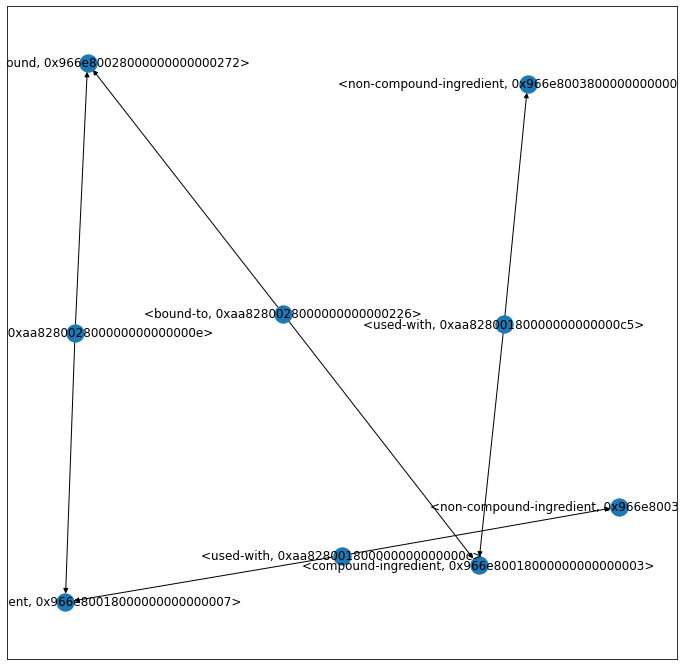

In [25]:
# testing one graph
g = graphs[0]
print('\n')
print(g.graph)
print('*'*100)
print('Nodes:')
print(g.nodes)
print('\nEdges:')
print(g.edges)
plt.figure(figsize=(12,12)) 
nx.draw_networkx(g, with_labels=True)
pass

In [2]:
cinnamon

NameError: name 'cinnamon' is not defined

In [3]:
match $f isa flavor-compound, has name $fn;
$fn = '(+)-alpha-phellandrene'; offset 0; limit 100;

SyntaxError: invalid syntax (<ipython-input-3-e19e7d649863>, line 1)

In [ ]:
match
# entities
$f0 isa flavor-compound;
$f0_name="(+)-alpha-phellandrene";
$c1 isa compound-ingredient, has name $c1_name;
$n2 isa non-compound-ingredient, has name $n2_name;
$c3 isa compound-ingredient, has name $c3_name;
$f4 isa flavor-compound;

# relations
$bt1 (flavor-compound-ingredient: $f0, flavor-compound-ingredient: $c1) isa bound-to;
$uw2 (ingredient-used-with: $c1, ingredient-used-with: $n2) isa used-with;
$uw3 (ingredient-used-with: $n2, ingredient-used-with: $c3) isa used-with;
$bt4 (flavor-compound-ingredient: $c3, flavor-compound-ingredient: $f4) isa bound-to;

# conditions 
not {$c1 is $c3;};
not {$f0 is $f4;};

get
$f0, $c1, $n2, $c3, $f4, $bt1, $uw2, $uw3, $bt4;
offset 0; limit 1;